In [ ]:
# Quantum Algorithms: From Theory to Practice
# Author: Nahomé VESVARD
# This notebook visualizes the experimental and simulation results
# details of the dates of the experiment - replace this with your own title
# Lab supervised by

### Required Software
Python 3.10+, `qiskit>=2.1`, `qiskit-ibm-runtime>=0.40`, `qiskit-aer`, `matplotlib`, `numpy`.



## 0. Prepare the Software Environment

This section verifies that the expected packages are installed and shows their versions.



Installation commands.

In [ ]:

 #Optional installs (uncomment if needed)
 !pip install -U "qiskit[all]>=2.1" "qiskit-ibm-runtime>=0.40" qiskit-aer matplotlib numpy scipy



Print package versions so you can confirm compatibility.


In [ ]:

from importlib.metadata import version, PackageNotFoundError

def v(pkg):
    try:
        return version(pkg)
    except PackageNotFoundError:
        return "NOT INSTALLED"

print("qiskit              :", v("qiskit"))
print("qiskit-aer          :", v("qiskit-aer"))
print("qiskit-ibm-runtime  :", v("qiskit-ibm-runtime"))


qiskit              : 2.2.1
qiskit-aer          : 0.17.2
qiskit-ibm-runtime  : 0.42.0


## 1. Connect to IBM Quantum Platform, list backends, and inspect device connectivity

### What is a backend?

A backend is where circuits run:
- Real backends are physical quantum devices with a finite number of qubits, a specific basis gate set (native gates), and a coupling map describing which qubits support direct two‑qubit operations.
- Simulator backends run on classical hardware and emulate circuits (optionally with noise models). They are useful when the required number of qubits or fidelity exceeds current hardware.

### What is the transpiler and what are native gates?

- Real devices support specific native (basis) gates and a coupling map (allowed two‑qubit links).
- The transpiler transforms your high‑level circuit into an ISA circuit expressed in native gates and routed on the device topology. This may insert SWAPs, decompose gates, and optimize depth.

You will authenticate, list backends (both real and simulators), select a real backend, draw its coupling map, and examine connectivity.



Authenticate to the IBM Quantum Platform using your tested snippet.


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# You can remove the token before submitting.
TOKEN = "0h0ymHkyYhJz_KydeBQ-zcGHC-QooHd5jvGrV9OePlpi"
INSTANCE = "crn:v1:bluemix:public:quantum-computing:us-east:a/b8d451767831460dbbb8ef691c15791c:9834fea3-d217-49f7-8bc0-7f2d409828e3::"  # or crn

#if not TOKEN or TOKEN.strip() in {"", "<0h0ymHkyYhJz_KydeBQ-zcGHC-QooHd5jvGrV9OePlpi>"}:
#    raise ValueError("You must paste your API key in TOKEN (it's required).")

service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
)

# Quick sanity check
backends_real = service.backends(operational=True, simulator=False)
print("OK. Found", len(backends_real), "real backends. Example:", [b.name for b in backends_real[:3]])


qiskit_runtime_service._discover_account:WARNING:2025-09-26 17:03:46,644: Loading account with the given token. A saved account will not be used.


OK. Found 2 real backends. Example: ['ibm_brisbane', 'ibm_torino']



List available real backends with basic info so you can choose one.


In [ ]:
rows = []
for b in service.backends(simulator=False):
    try:
        rows.append((b.name, b.num_qubits, len(b.target.operation_names)))
    except Exception:
        rows.append((b.name, getattr(b, "num_qubits", "n/a"), "n/a"))

print("Real backends (name, num_qubits, |basis_ops|):")
for r in sorted(rows, key=lambda x: (-int(x[1]) if str(x[1]).isdigit() else 0, x[0])):
    print(r)

Real backends (name, num_qubits, |basis_ops|):
('ibm_torino', 133, 9)
('ibm_brisbane', 127, 9)



List simulator backends as well. These are useful if your circuit needs more qubits or if you want noise‑free references. The fake backends from `channel="local"` are useful for mimicing specific real backends.


In [ ]:
local_service = QiskitRuntimeService(
    channel="local",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
)

sim_rows = []
for b in local_service.backends():
    sim_rows.append((b.name, getattr(b, "num_qubits", "varies"), "simulator"))

print("Simulator backends:")
for r in sim_rows:
    print(r)

Simulator backends:
('fake_algiers', 27, 'simulator')
('fake_almaden', 20, 'simulator')
('fake_armonk', 1, 'simulator')
('fake_athens', 5, 'simulator')
('fake_auckland', 27, 'simulator')
('fake_belem', 5, 'simulator')
('fake_boeblingen', 20, 'simulator')
('fake_bogota', 5, 'simulator')
('fake_brisbane', 127, 'simulator')
('fake_brooklyn', 65, 'simulator')
('fake_burlington', 5, 'simulator')
('fake_cairo', 27, 'simulator')
('fake_cambridge', 28, 'simulator')
('fake_casablanca', 7, 'simulator')
('fake_cusco', 127, 'simulator')
('fake_essex', 5, 'simulator')
('fake_fez', 156, 'simulator')
('fake_fractional', 5, 'simulator')
('fake_geneva', 27, 'simulator')
('fake_guadalupe', 16, 'simulator')
('fake_hanoi', 27, 'simulator')
('fake_jakarta', 7, 'simulator')
('fake_johannesburg', 20, 'simulator')
('fake_kawasaki', 127, 'simulator')
('fake_kolkata', 27, 'simulator')
('fake_kyiv', 127, 'simulator')
('fake_kyoto', 127, 'simulator')
('fake_lagos', 7, 'simulator')
('fake_lima', 5, 'simulator')
('


Select a real backend that is the least busy and has at least `MIN_QUBITS` qubits.


In [ ]:
MIN_QUBITS = 8   # we aim for 6-8‑qubit QFT later
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=MIN_QUBITS)
print("Selected backend:", backend.name, "| num_qubits:", backend.num_qubits)

Selected backend: ibm_brisbane | num_qubits: 127



Display the device coupling map and print basic properties such as supported operations and `dt`.


Basis operations: dict_keys(['x', 'reset', 'sx', 'measure', 'ecr', 'delay', 'id', 'if_else', 'rz'])
dt (s): 5e-10


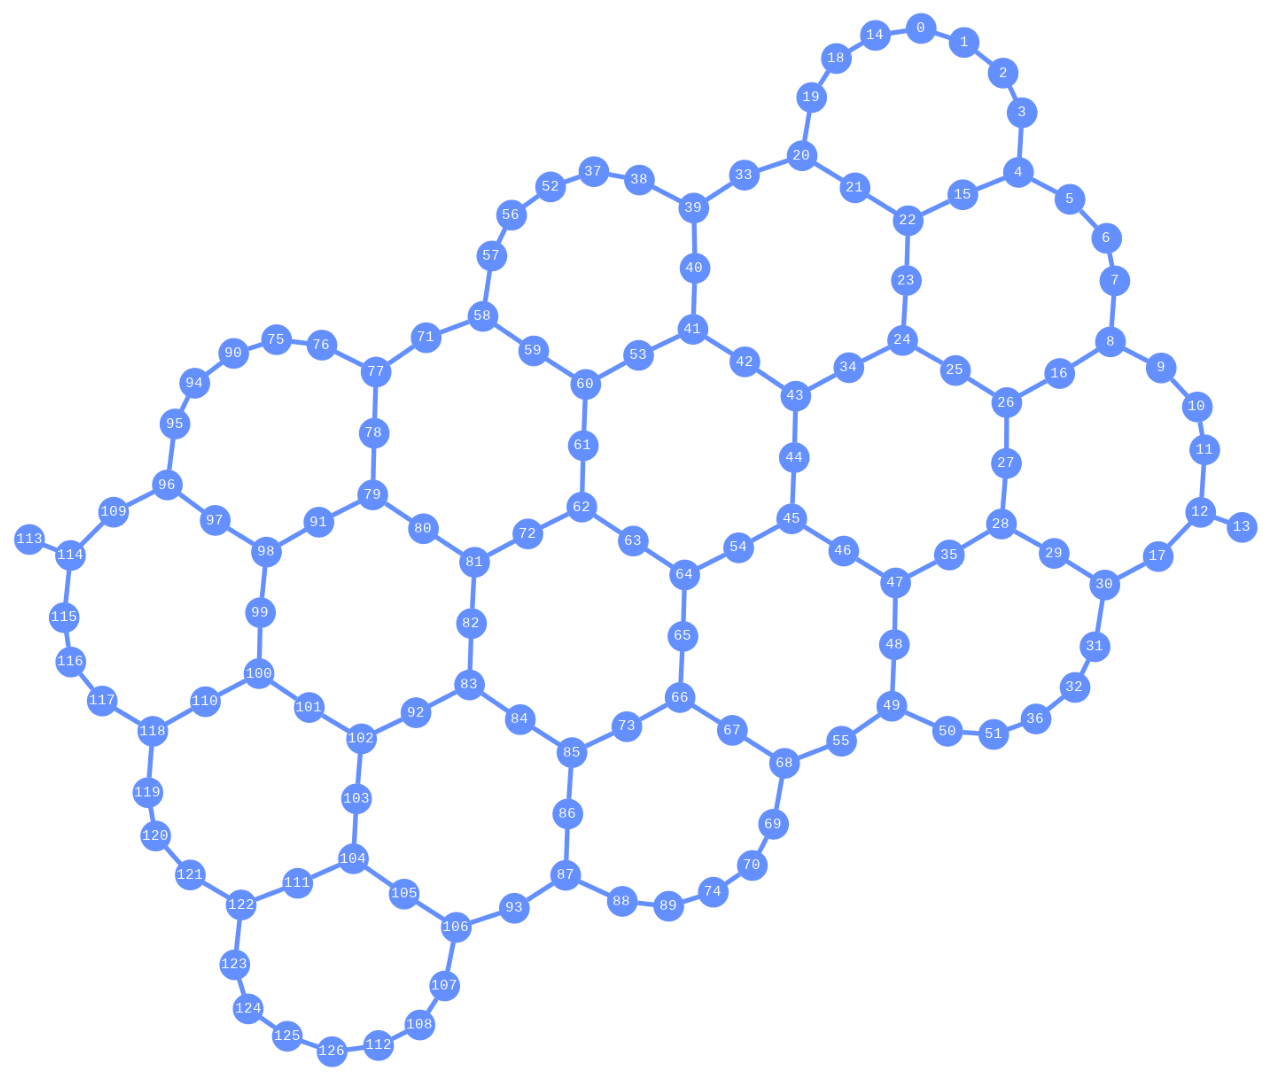

In [ ]:
from qiskit.visualization import plot_coupling_map
import matplotlib.pyplot as plt

print("Basis operations:", backend.target.operation_names)
print("dt (s):", getattr(backend, "dt", "N/A"))

plot_coupling_map(backend.num_qubits, None, backend.coupling_map.get_edges())


Extract and prints the connectivity in multiple forms so you can check paths between qubits:
- Edge list (undirected)
- Adjacency list (neighbors per qubit)
- Adjacency matrix

Then it prompts you to pick the set of qubits you intend to use. This is helpful to plan long‑range interactions for the QFT.


In [ ]:
import numpy as np

def coupling_edges(backend):
    # Try multiple ways to get edges for robustness across versions
    try:
        cmap = backend.coupling_map
        if hasattr(cmap, 'get_edges'):
            return list(cmap.get_edges())
        if isinstance(cmap, (list, tuple)):
            return list(map(tuple, cmap))
    except Exception:
        pass
    try:
        # Build from target
        cm = backend.target.build_coupling_map()
        if hasattr(cm, 'get_edges'):
            return list(cm.get_edges())
    except Exception:
        pass
    try:
        return list(map(tuple, backend.configuration().coupling_map))
    except Exception:
        return []

NQ = backend.num_qubits
edges = coupling_edges(backend)
# make undirected unique edges
u_edges = set(tuple(sorted(e)) for e in edges)
adj = {i: set() for i in range(NQ)}
for (a,b) in u_edges:
    adj[a].add(b); adj[b].add(a)

print("Connectivity (edge list, undirected, first 50):")
print(sorted(list(u_edges))[:50], "...")  # print first 50 for brevity

print("\nAdjacency list (neighbors per qubit):")
for q in range(NQ):
    print(f"q{q}: {sorted(adj[q])}")

# Adjacency matrix
A = np.zeros((NQ, NQ), dtype=int)
for a,b in u_edges:
    A[a,b] = 1; A[b,a] = 1
print("\nAdjacency matrix shape:", A.shape, " (showing top-left 16x16 block if larger)")
print(A[:16,:16])


Connectivity (edge list, undirected, first 50):
[(0, 1), (0, 14), (1, 2), (2, 3), (3, 4), (4, 5), (4, 15), (5, 6), (6, 7), (7, 8), (8, 9), (8, 16), (9, 10), (10, 11), (11, 12), (12, 13), (12, 17), (14, 18), (15, 22), (16, 26), (17, 30), (18, 19), (19, 20), (20, 21), (20, 33), (21, 22), (22, 23), (23, 24), (24, 25), (24, 34), (25, 26), (26, 27), (27, 28), (28, 29), (28, 35), (29, 30), (30, 31), (31, 32), (32, 36), (33, 39), (34, 43), (35, 47), (36, 51), (37, 38), (37, 52), (38, 39), (39, 40), (40, 41), (41, 42), (41, 53)] ...

Adjacency list (neighbors per qubit):
q0: [1, 14]
q1: [0, 2]
q2: [1, 3]
q3: [2, 4]
q4: [3, 5, 15]
q5: [4, 6]
q6: [5, 7]
q7: [6, 8]
q8: [7, 9, 16]
q9: [8, 10]
q10: [9, 11]
q11: [10, 12]
q12: [11, 13, 17]
q13: [12]
q14: [0, 18]
q15: [4, 22]
q16: [8, 26]
q17: [12, 30]
q18: [14, 19]
q19: [18, 20]
q20: [19, 21, 33]
q21: [20, 22]
q22: [15, 21, 23]
q23: [22, 24]
q24: [23, 25, 34]
q25: [24, 26]
q26: [16, 25, 27]
q27: [26, 28]
q28: [27, 29, 35]
q29: [28, 30]
q30: [17, 29, 


**Your task: connectivity check**
- Choose a contiguous set of qubits you intend to use for the QFT (e.g., 6 or 8 qubits). Are those qubits well connected on your backend, or will the transpiler need to insert many SWAPs?

*If I choose 46,47,48,55,64,65 which are contiguous, we clearly see on the coupling map that they are all aligned, so the transpiler will not need to add many swaps.*

- If two qubits in your set are not directly connected, what is the shortest path between them according to the adjacency list?

*the shortest path between let's say 48 and 65 would be by swapping 55 and 65, swapping 48 and 47 and then either swap 48 and 46 or swap 65 with 46 (3 swaps in total).*



Build a tiny 3‑qubit circuit, transpile it for the backend, and display the mapped ISA circuit with depth and gate counts. This illustrates how mapping to native gates and coupling works.


Logical circuit:


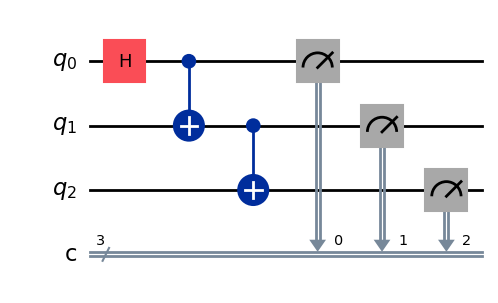

Mapped (ISA) circuit:


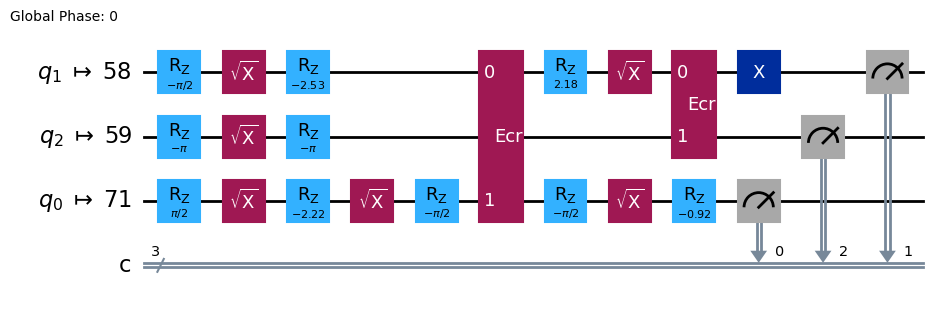

Layout mapping: TranspileLayout(initial_layout=Layout({
71: <Qubit register=(3, "q"), index=0>,
58: <Qubit register=(3, "q"), index=1>,
59: <Qubit register=(3, "q"), index=2>,
0: <Qubit register=(124, "ancilla"), index=0>,
1: <Qubit register=(124, "ancilla"), index=1>,
2: <Qubit register=(124, "ancilla"), index=2>,
3: <Qubit register=(124, "ancilla"), index=3>,
4: <Qubit register=(124, "ancilla"), index=4>,
5: <Qubit register=(124, "ancilla"), index=5>,
6: <Qubit register=(124, "ancilla"), index=6>,
7: <Qubit register=(124, "ancilla"), index=7>,
8: <Qubit register=(124, "ancilla"), index=8>,
9: <Qubit register=(124, "ancilla"), index=9>,
10: <Qubit register=(124, "ancilla"), index=10>,
11: <Qubit register=(124, "ancilla"), index=11>,
12: <Qubit register=(124, "ancilla"), index=12>,
13: <Qubit register=(124, "ancilla"), index=13>,
14: <Qubit register=(124, "ancilla"), index=14>,
15: <Qubit register=(124, "ancilla"), index=15>,
16: <Qubit register=(124, "ancilla"), index=16>,
17: <Qubit 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from IPython.display import display

qc = QuantumCircuit(3, 3)
qc.h(0); qc.cx(0,1); qc.cx(1,2); qc.measure(range(3), range(3))
print("Logical circuit:")
display(qc.draw("mpl"))

pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
isa = pm.run(qc)
print("Mapped (ISA) circuit:")
display(isa.draw("mpl"))
print("Layout mapping:", isa.layout)
print("Depth:", isa.depth(), "Gate counts:", isa.count_ops())


**Questions for you**
- From the coupling map and adjacency information, which pairs in your chosen register are long‑range and likely to incur routing overhead?

*Pairs that are more likely to be long range are the two qubits that are the most 'far away' from each other, so in my choosen register it is 64 and 48 (the become adjacent after 4 swaps).*

- Which native two‑qubit gates does your backend support, and how might that affect the QFT structure?


*At the end of the cell above, we can read the gatesthat the backends support : rz, sx, measure and cz (and also the number of time they're used in the code)*

*But only cz acts on two qubits since it is the entanglement gate.*
*rz : rotation around z axis (1 qubit)*
*sx : rotation of TT/2 around x axis (1 qubit)*
*measure : measure the state of a qubit (1 qubit)*

*The QFT is made of Hadamard gates and controlled rotations gates. Depending on the native gates in our backend, those operations involve more or less native gates when they are transpiled ; the set of native gates thus impact the complexity of the QFT. This is true in particular for the controlled rotation operation that highly depend on which 2 qubit gate you're using. So the nature the 2 qubit gate affects how efficiently the compilation of the QFT is.*


## 2. Quantum Random Number Generator (QRNG)

### What is a QRNG and how is it done with a quantum circuit?

A quantum random number generator (QRNG) leverages the inherent randomness of measurement outcomes for superposed states.
- Prepare each qubit in $|+\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$ by applying a Hadamard gate.
- Measure in the computational basis; each qubit yields 0 or 1 with probability 1/2 (ideally), producing unbiased random bits.
- Deviations from ideality reflect device noise, bias, and correlations.

You will build a QRNG circuit, run it on hardware with `SamplerV2`, optionally compare with Aer, and assess bias and correlations.



Build a QRNG circuit of H gates followed by measurements on all qubits.


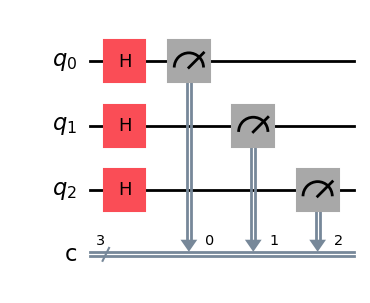

In [ ]:
from qiskit import QuantumCircuit
from IPython.display import display

def build_qrng(n_qubits: int = 3):
    """Return a circuit that applies H to all qubits and measures them."""
    qc = QuantumCircuit(n_qubits, n_qubits)
    for q in range(n_qubits):
        qc.h(q)
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

qrng_qc = build_qrng(3)
display(qrng_qc.draw("mpl"))


Transpile the QRNG circuit for the selected backend and runs it with `SamplerV2` to get bitstrings from hardware.


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager

shots = 4096
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
isa_qrng = pm.run(qrng_qc)

sampler = Sampler(mode=backend)
job = sampler.run([(isa_qrng,)], shots=shots)
result = job.result()
data = result[0].data

# data.meas doesn't work here. We can check what data contains:
print(data.keys())
# The reason it contains c instad of meas is that we used measure()
# instead of mesaure_all() in the circuit

bitstrings = result[0].data.c.get_bitstrings()
print("Example shots:", bitstrings[:10])

dict_keys(['c'])
Example shots: ['000', '100', '110', '010', '100', '001', '101', '000', '111', '001']



Compare hardware results with a local Aer simulator using the same SamplerV2 schema.


In [ ]:
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator

aer_sampler = BackendSamplerV2(backend=AerSimulator())
aer_job = aer_sampler.run([(qrng_qc,)], shots=shots)
aer_res = aer_job.result()
aer_bitstrings = aer_res[0].data.c.get_bitstrings()
print("Aer example shots:", aer_bitstrings[:10])

Aer example shots: ['101', '000', '000', '111', '100', '111', '111', '001', '010', '001']



Convert lists of bitstrings into NumPy arrays for statistical analysis.


In [ ]:
import numpy as np

def bitstrings_to_array(bitstrings, n_qubits):
    return np.array([[int(c) for c in s] for s in bitstrings], dtype=int)

nq = qrng_qc.num_qubits
X = bitstrings_to_array(bitstrings, nq)          # hardware
X_aer = bitstrings_to_array(aer_bitstrings, nq)  # simulator (optional)

print("Shape (shots, n_qubits):", X.shape)
print("First 5 shots (hardware):\n", X[:5])

Shape (shots, n_qubits): (4096, 3)
First 5 shots (hardware):
 [[0 0 0]
 [1 0 0]
 [1 1 0]
 [0 1 0]
 [1 0 0]]



Compute monobit and run tests, temporal autocorrelation per qubit, spatial correlation across qubits, and plot histograms.


Q0: monobit p1=0.4958 (z=-0.53), runs=2070 (z=0.66)
Q1: monobit p1=0.5078 (z=1.00), runs=2115 (z=2.08)
Q2: monobit p1=0.5007 (z=0.09), runs=2090 (z=1.28)


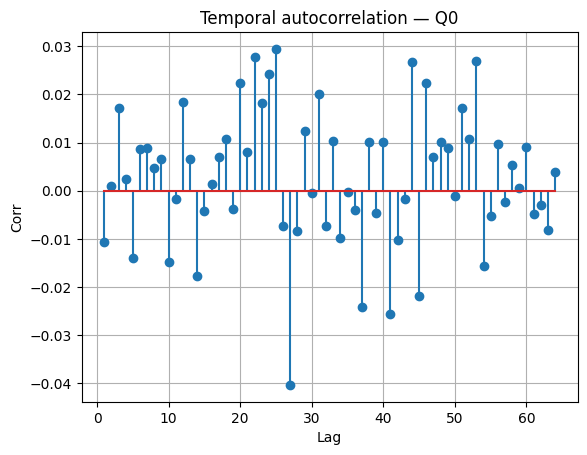

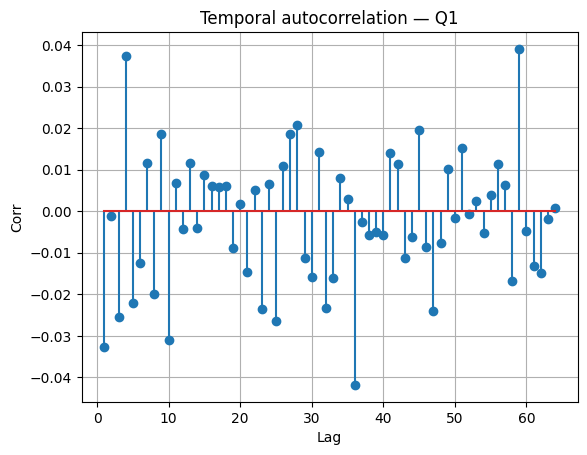

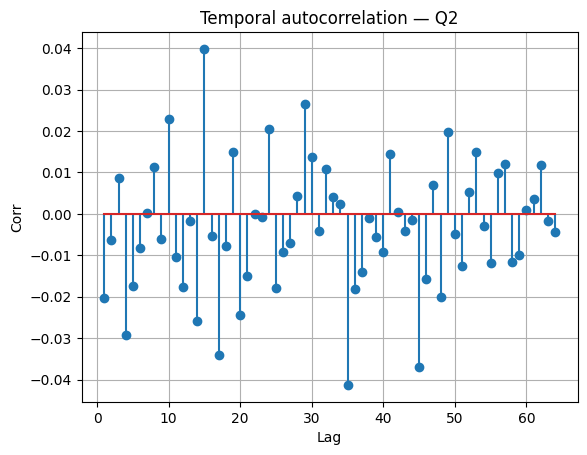

Spatial correlation matrix (hardware):
 [[ 1.    -0.009  0.015]
 [-0.009  1.     0.019]
 [ 0.015  0.019  1.   ]]


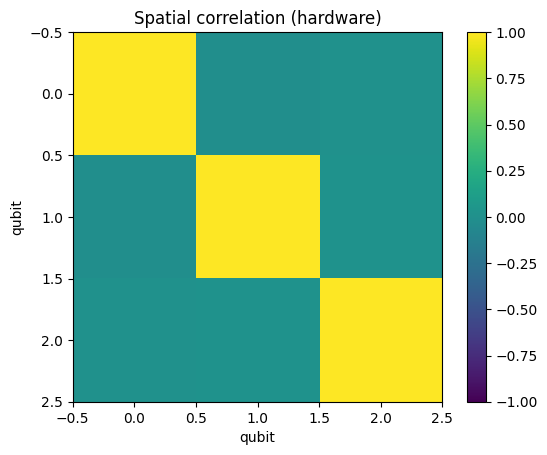

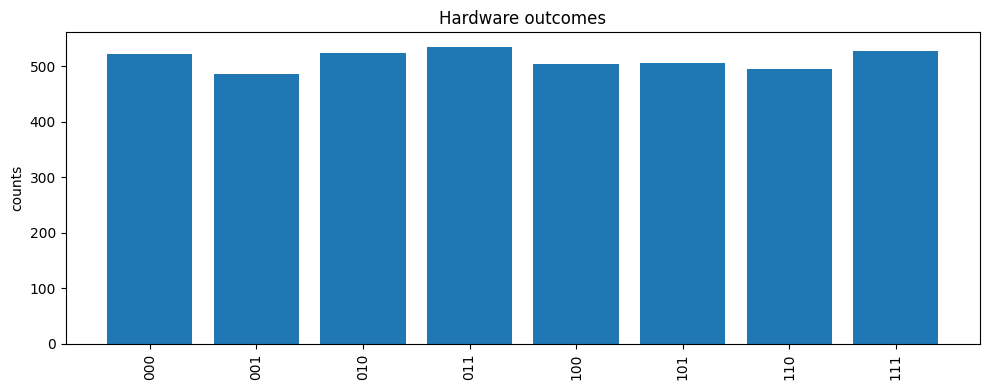

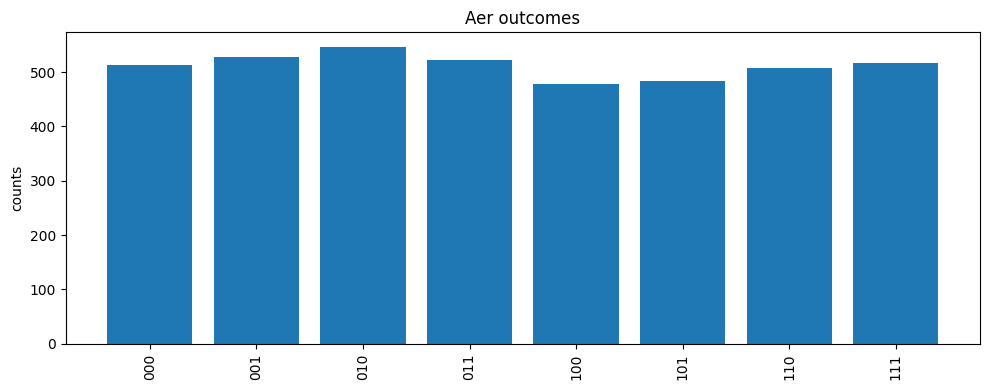

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Compute proportion of 1s and how much it deviates from expected, per qubit.
def monobit_test(x):
    N = x.size
    p_hat = x.sum()/N                   # Compute proportion of 1s
    z = (p_hat - 0.5)/np.sqrt(0.25/N)   # Compute z-score, that is, number of std deviations from mean
    return p_hat, z

# Number of bit flips and how much it deviates from expected, per qubit.
def runs_test(x):
    diffs = np.diff(x)
    runs = 1 + np.sum(diffs != 0) if len(x) else 0     # Number of runs. A run is a sequence of consecutive identical bits.
    n1, n0 = x.sum(), len(x)-x.sum()                   # Number of 1s and 0s
    if n1==0 or n0==0:
        return runs, np.nan
    mean = 1 + 2*n1*n0/(n1+n0)                                          # Mean number of runs, given n1 and n0 and assuming perfect randomness
    var = (2*n1*n0*(2*n1*n0 - n1 - n0)) / (((n1+n0)**2)*(n1+n0-1))      # Expected variance, assuming perfect randomness
    z = (runs - mean)/np.sqrt(var) if var>0 else np.nan                 # z-score for runs
    return runs, z

# Correlations between lagged measurement outcomes, per qubit.
def autocorr(x, max_lag=32):
    y = 2*x - 1             # Map 0->-1, 1->1
    y = y - y.mean()        # Ensure mean is zero
    ac = []
    den = np.dot(y, y)      # Denominator for autocorrelation
    for k in range(1, max_lag+1):
        if len(y) <= k or den == 0:
            ac.append(np.nan); continue
        num = np.dot(y[:-k], y[k:]) # Numerator for lag k
        ac.append(num/den)
    return np.array(ac)

# Correlations between outcomes of different qubits.
def spatial_corr(X):
    return np.corrcoef(X, rowvar=False)   # Correlation matrix between columns (qubits)

# Per‑qubit stats
shots, nq = X.shape
max_lag = min(64, shots-1)
for q in range(nq):
    p, z = monobit_test(X[:, q])
    r, zr = runs_test(X[:, q])
    print(f"Q{q}: monobit p1={p:.4f} (z={z:.2f}), runs={r} (z={zr:.2f})")

# Temporal AC plots
for q in range(nq):
    ac = autocorr(X[:, q], max_lag=max_lag)
    plt.figure()
    plt.stem(range(1, 1+len(ac)), ac)
    plt.title(f"Temporal autocorrelation — Q{q}")
    plt.xlabel("Lag"); plt.ylabel("Corr"); plt.grid(True)
    plt.show()

# Spatial correlation heatmap
C = spatial_corr(X)
print("Spatial correlation matrix (hardware):\n", np.round(C, 3))
plt.figure(); plt.imshow(C, vmin=-1, vmax=1); plt.colorbar(); plt.title("Spatial correlation (hardware)")
plt.xlabel("qubit"); plt.ylabel("qubit"); plt.show()

# Histograms
def plot_counts_histogram(bitstrings, title="Histogram of outcomes"):
    ctr = Counter(bitstrings)
    labels, values = zip(*sorted(ctr.items()))
    plt.figure(figsize=(10,4))
    plt.bar(labels, values)
    plt.xticks(rotation=90)
    plt.ylabel("counts"); plt.title(title); plt.tight_layout(); plt.show()

plot_counts_histogram(bitstrings, title="Hardware outcomes")
plot_counts_histogram(aer_bitstrings, title="Aer outcomes")


**Questions for you**
- Compare monobit and runs test z‑scores across qubits. Which qubit appears most biased, and why might that be?

*Q0 has the highest (in absolute value) z-scores out of the three for the monobit and the runs test, therefore it appears to be more biased. Although the 3 qubits are identical and go through the same operations(H and measurement), one qubit could be more biased because its readout skew towards one of the two outcomes.
In particular here Q0 tends to be measured a bit more in the state '1', so in its assignment matrix we might find that P(1|0) > P(0|1). Those probabilities are set by the hardwareand the setting of the measurement.*

*Another reason could be the mis-calibration of the hardware supposed to act on the real qubit as a H gate, which leads to doing the 'wrong' operation (not a perfect H gate) and thus lead to biased results.*

- Do you observe temporal autocorrelation on any qubit? What hardware or software effects could explain it?

*Out of the three autocorrelation graphs over time we notice that there's very few blue dots that stands perfectly on the '0' line, so we do not osberve any temporal correlation for our three qubits.*

*Again, the readout bias could be one of the cause. Another hardware problem could be the resonator ring-down effect, which is when the measurment is affected by the previous one because the photons from the previous shot did not entirely decay and continue to interact with the qubit when the next measurement is done.

*As for software, choosing a small delay in between two shots is likely to create correlation between shots over time (since we do not provide to the qubits enough time to completely relax). Bias can also come from idle/relaxation during measurement.*

- If spatial correlation shows structure, what coupling or crosstalk mechanisms could produce it?

*Given the low value of the off-diagonals terms of the correlation matrix, ~5.10e-3 or less, there's no structure here.*

*However, structure could happen under measurement induced effects (crosstalk) because of phenomenom like the resonator ring-down (described above), or leakage and distrotion of the tones of distinct quibits on a shared readout line. This shows up as correlated errors between 2 or more qubits. More correlation could come from leakage of the pulse, leading to unintentional rotation of nearby qubits. And even when we're not acting on any qubits, there's a static interaction in between qubits called the Cross-Kerr (or ZZ) coupling interaction which shifts their phase and thus induce correlation and errors.*

- Propose a circuit‑only modification to reduce bias or correlations, and predict its effect on the metrics above.

*We need to cancel correlation by implementing decoupling mechanism to our circuit. First we can measure the qubits one at a time, and add Dynamical Decoupling (DD) for the two idle qubits. As it says in the IBM quantum documentation about the DD : "Each inserted pulse sequence amounts to an identity operation, but the physical presence of the pulses has the effect of suppressing errors."
With that we can expect less spatial and temporal correlation.*

*We can also use readout error mitigation techniques, via the calibration of eah of the assignement matrix of our qubits. This will strongly reduce monobit bias, and drive the z-score close to 0.*



## 3. Quantum Fourier Transform (QFT) with a single‑tone phase oracle (6-8 qubits)


### What is the QFT and how is it implemented as a quantum circuit?

The QFT maps computational basis states to equal‑magnitude superpositions with linearly increasing phases, such that the number of periods equals the input state. On $n$ qubits it uses:
- A ladder of Hadamards and controlled‑phase rotations with angles $\pi/2^{m}$.
- A final bit‑reversal (swap) stage.

For a discrete tone at bin $k$ we define a phase oracle $O_k: \ket{t} \rightarrow e^{2\pi i k t/2^n}\ket{t}$. Starting in the uniform superposition, applying $O_k$ then inverse QFT ideally yields $\ket{k}$. This highlights the noise impact when scaled to 8 qubits.

**Note**: The QFT is usually defined acting on computational basis states as

$$
\ket{x} \rightarrow \frac{1}{\sqrt{N}}\sum_{k = 0}^{N-1}\omega_N ^{xk}\ket{k}
$$

whereas the classical Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to a new vector $(y_0,..., y_{N-1})$ according to the formula

$$
y_k = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1}\omega_{N}^{-jk}x_j
$$

where $\omega_N = \exp(2\pi i / N)$. The important thing to note here is that there is a difference in the signs used in the exponentials. **This implies that the QFT has the same effect as the inverse DFT, and vice versa**. This is why we must apply the inverse QFT in the following exercise, and not the QFT.


Define helper circuits for inverse QFT and for a diagonal single‑tone phase oracle using per‑qubit phase gates that encode the tone index.


In [ ]:
from qiskit import QuantumCircuit
from math import pi
import numpy as np

def inverse_qft(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name=f"iQFT({n})")
    # bit‑reversal
    for i in range(n//2):
        qc.swap(i, n-1-i)
    for j in range(n):
        qc.h(j)
        for k1 in range(j+1, n):
            qc.cp(-pi/2**(k1-j), k1, j)
    return qc

def tone_oracle(n: int, k: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name=f"Oracle(k={k})")
    for j in range(n):
        phi_j = 2 * np.pi * k / (2**(n-j))
        qc.p(phi_j, j)  # Phase gate on qubit j
    return qc


Set the QFT size to 8 qubits by default (use 6 if you prefer). It prints the intended target bitstring for the chosen tone index.


In [ ]:
n = 6       # choose 8 or 6; adjust if your backend lacks enough qubits
N = 2**n
k = 37              # 0 <= k < N; pick any tone bin

print(f"Using n={n} (N={N}) and tone bin k={k}")
print("Target bitstring:", format(k, f"0{n}b"))

Using n=6 (N=64) and tone bin k=37
Target bitstring: 100101



Build a classical reference signal $x[t] = \exp(2π i k t / N)$, compute its FFT, and reports the dominant bins. For $N=256$ ($n=8$), this is still fast.


In [ ]:
import numpy as np

t = np.arange(N)
x = np.exp(2j*np.pi*k*t/N)
X = np.fft.fft(x)
P = np.abs(X)**2

tops = sorted([(i, float(P[i])) for i in range(N)], key=lambda z: -z[1])[:5]
print("Top 5 FFT bins by power:", tops)

Top 5 FFT bins by power: [(37, 4096.0), (9, 1.951632750568797e-26), (1, 1.9241159611558254e-26), (46, 8.66008150537312e-27), (28, 8.638636787200366e-27)]



Build the ideal circuit $H^{\otimes n}$ → Oracle(k) → InvQFT and evaluate the ideal statevector to confirm that the probability at $\ket{k}$ is near 1.


In [ ]:
from qiskit.quantum_info import Statevector

qc_sim = QuantumCircuit(n, n)
# Uniform superposition
for q in range(n):
    qc_sim.h(q)
qc_sim.append(tone_oracle(n, k).to_gate(label="Oracle"), range(n))
qc_sim.append(inverse_qft(n).to_gate(label="InvQFT"), range(n))
qc_sim.measure(range(n), range(n))

sv = Statevector.from_instruction(qc_sim.remove_final_measurements(inplace=False))
probs = np.abs(sv.data)**2
print("Ideal probability at k:", probs[k], " (should be ~1.0)")

Ideal probability at k: 0.999999999999998  (should be ~1.0)



 Attempt to transpile the 8-6 qubit QFT pipeline for your selected real backend, reports depth, gate counts, and layout. If your backend lacks enough qubits, it will notify you to switch backends or reduce n.


Transpiled large QFT circuit:
Depth: 157 Gate counts: OrderedDict({'rz': 143, 'sx': 77, 'ecr': 50, 'x': 15})
Layout: TranspileLayout(initial_layout=Layout({
52: <Qubit register=(6, "q"), index=0>,
71: <Qubit register=(6, "q"), index=1>,
59: <Qubit register=(6, "q"), index=2>,
56: <Qubit register=(6, "q"), index=3>,
58: <Qubit register=(6, "q"), index=4>,
57: <Qubit register=(6, "q"), index=5>,
0: <Qubit register=(121, "ancilla"), index=0>,
1: <Qubit register=(121, "ancilla"), index=1>,
2: <Qubit register=(121, "ancilla"), index=2>,
3: <Qubit register=(121, "ancilla"), index=3>,
4: <Qubit register=(121, "ancilla"), index=4>,
5: <Qubit register=(121, "ancilla"), index=5>,
6: <Qubit register=(121, "ancilla"), index=6>,
7: <Qubit register=(121, "ancilla"), index=7>,
8: <Qubit register=(121, "ancilla"), index=8>,
9: <Qubit register=(121, "ancilla"), index=9>,
10: <Qubit register=(121, "ancilla"), index=10>,
11: <Qubit register=(121, "ancilla"), index=11>,
12: <Qubit register=(121, "ancilla"

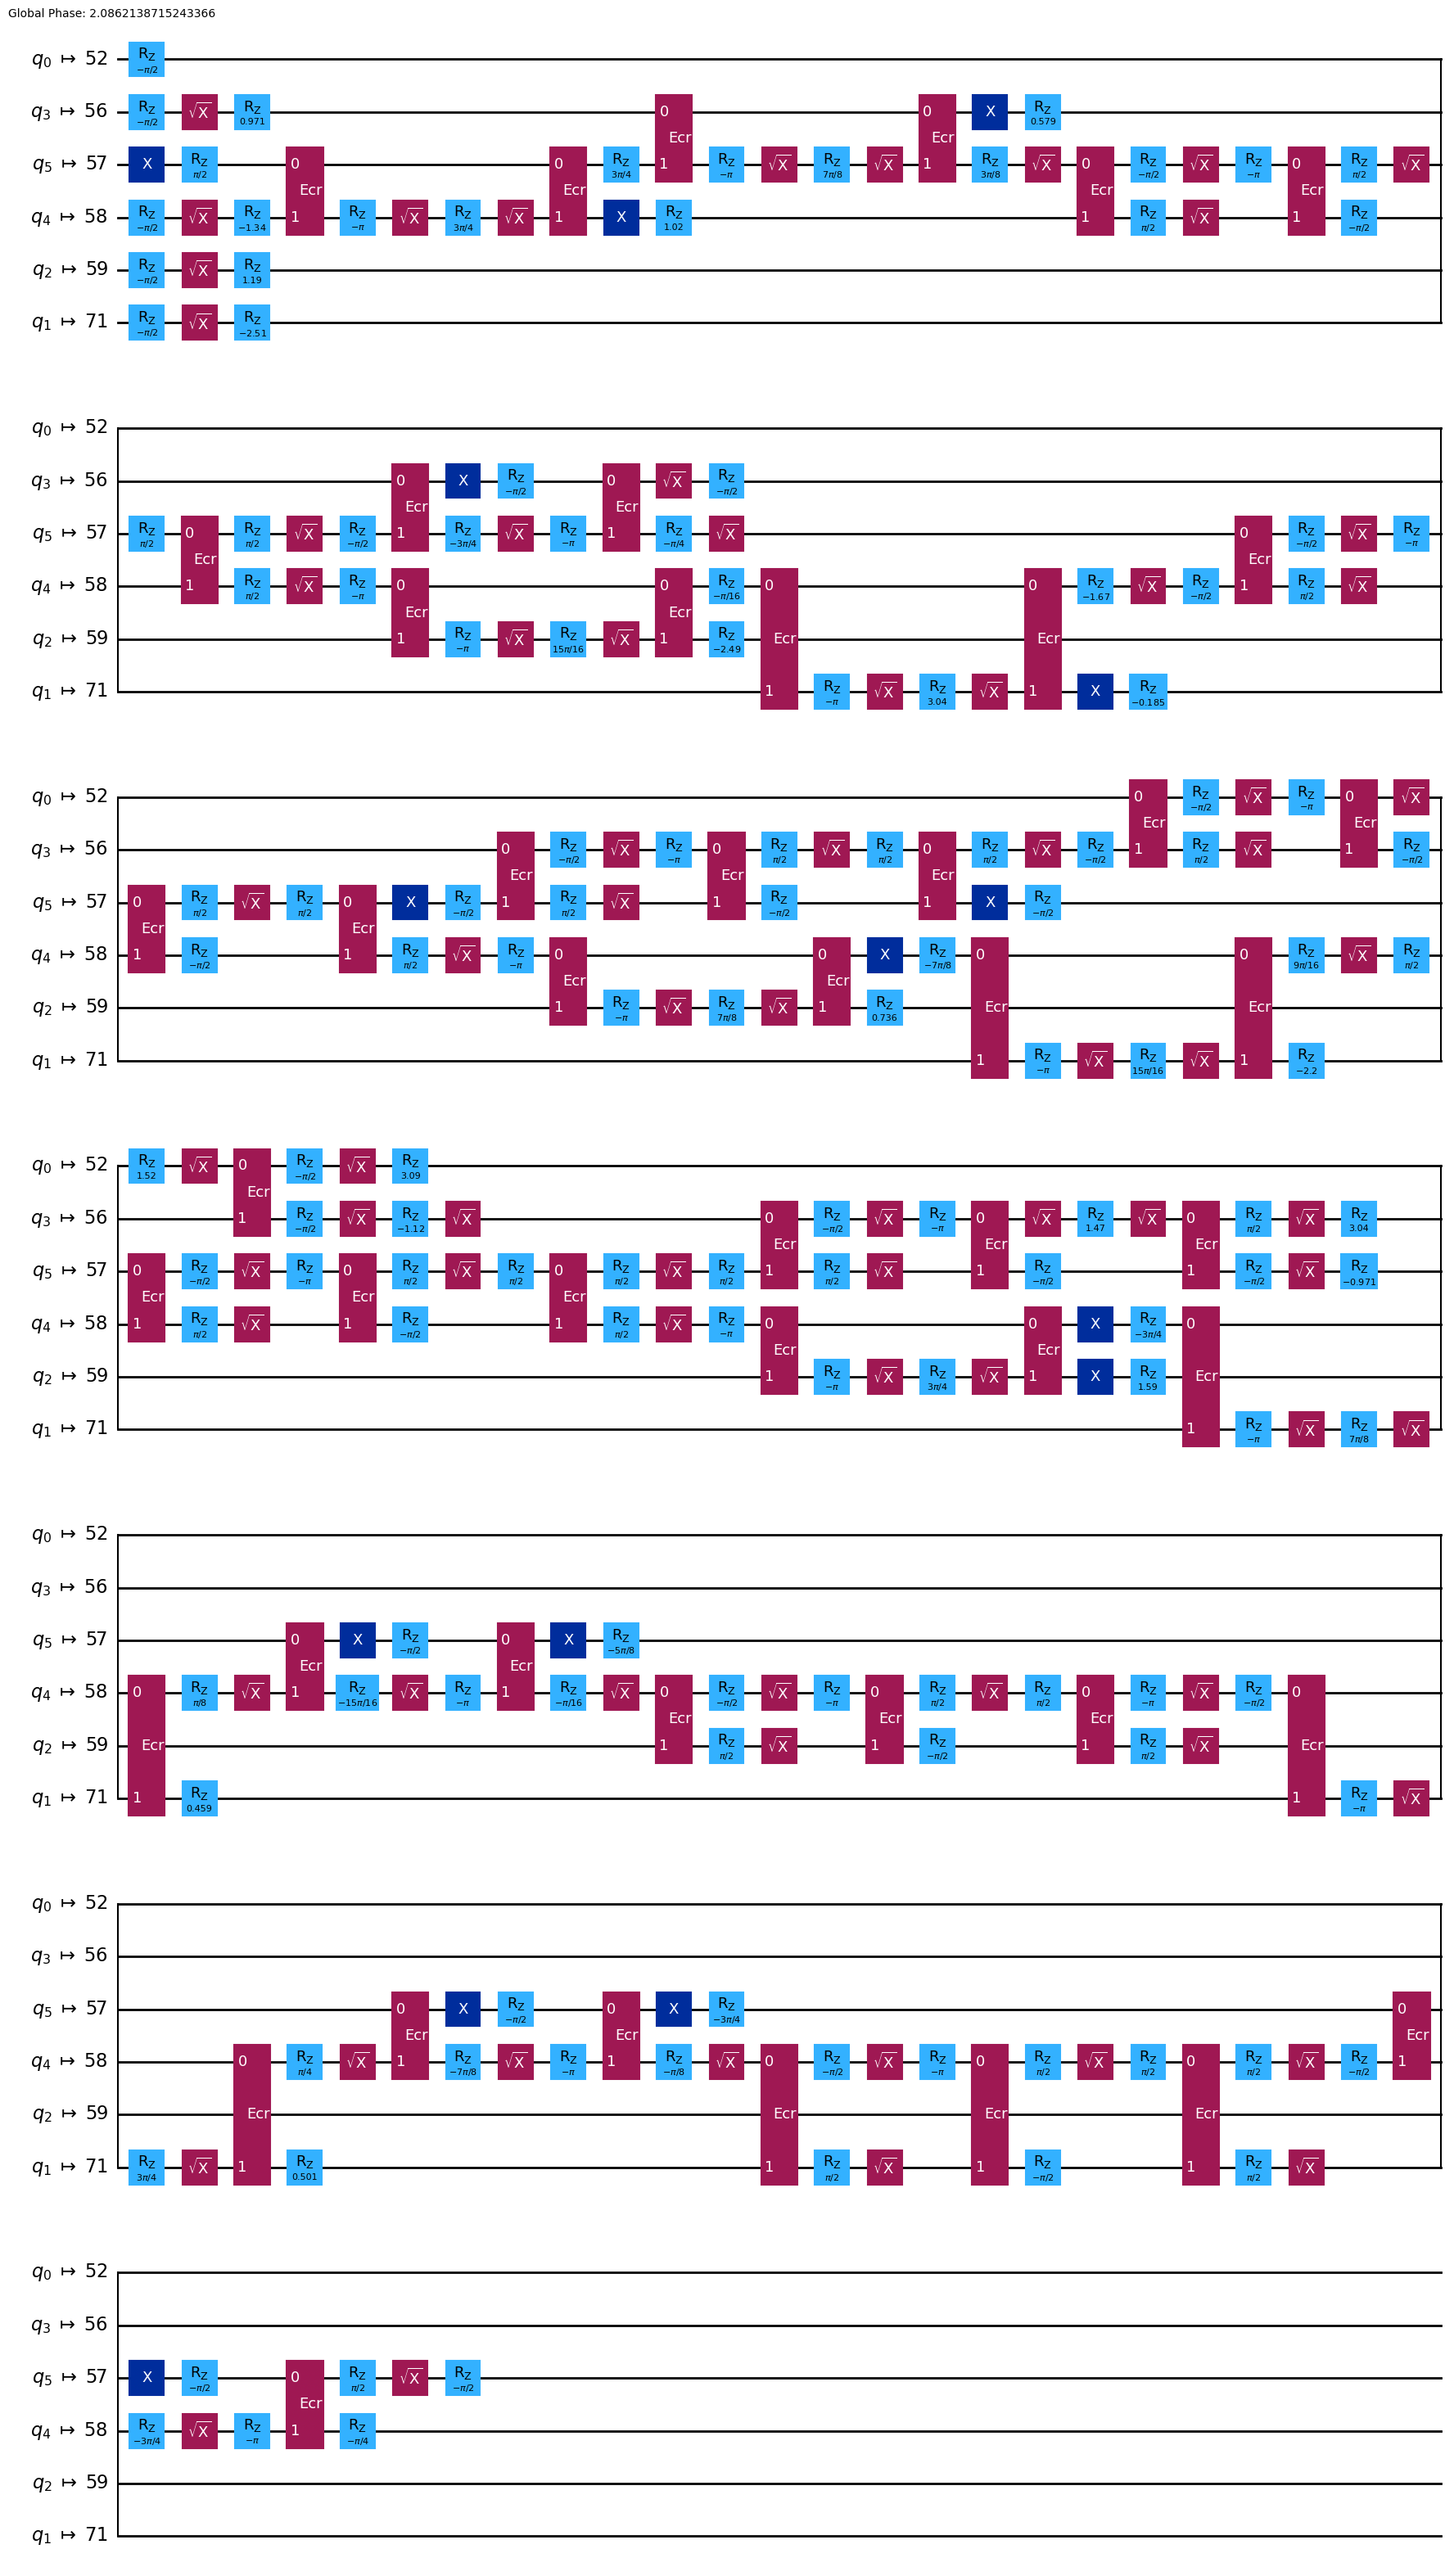

In [ ]:
from qiskit.transpiler import generate_preset_pass_manager
from IPython.display import display

if backend.num_qubits < n:
    print(f"Selected backend {backend.name} has only {backend.num_qubits} qubits; reduce n or choose another backend.")
else:
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    isa_large = pm.run(qc_sim.remove_final_measurements(inplace=False))  # transpile without classical bits
    print("Transpiled large QFT circuit:")
    print("Depth:", isa_large.depth(), "Gate counts:", isa_large.count_ops())
    print("Layout:", isa_large.layout)
    display(isa_large.draw("mpl"))

isa_large_w_measurement = pm.run(qc_sim)


**Your task: scaling effects**
- Record the depth and two‑qubit gate count for n = 8 and n = 6. How does it scale with n?

*For n  = 8 : depth = 201, cz = 93*

*For n = 6 : depth = 118, cz = 46*

*So we see that both depth and number of two-qubit gates grow rapidly with n, in fact the QFT uses a number of gate that gro O(n²).*

- Using the connectivity information from Section 1, explain which long‑range interactions are most costly to route.

*Since the QFT requires lots of controlled phase operation, which itself contain a couple or more two-qubit gates, it increases the depth rapidly. Furthermore, when the two qubits involved are 'far away' from each other, an additional number of swaps is required. This long-range interaction is the most costly to route.*


Run the large QFT pipeline on a noisy Aer simulator as a baseline to visualize noise impact at scale. You can adjust noise parameters.


In [ ]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.primitives import BackendSamplerV2

# Toy noise parameters; tune to explore sensitivity
p1, p2 = 0.001, 0.01
pr = 0.02

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['h', 'p', 'rz', 'x', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx', 'cp', 'swap'])
ro = ReadoutError([[1-pr, pr],[pr, 1-pr]])
noise_model.add_all_qubit_readout_error(ro)

sim = AerSimulator(noise_model=noise_model)
sampler_noisy = BackendSamplerV2(backend=sim)

qc_sim = qc_sim.decompose()
res_noisy = sampler_noisy.run([(qc_sim,)], shots=4096).result()[0]
counts_noisy = res_noisy.data.c.get_counts()
total_noisy = sum(counts_noisy.values())
target_bs = format(k, f"0{n}b")
pk_noisy = counts_noisy.get(target_bs, 0)/total_noisy if total_noisy else 0.0

print(f"Noisy Aer Pr[measure k={k} ({target_bs})] ≈ {pk_noisy:.3f}")
print("Top outcomes:", sorted(counts_noisy.items(), key=lambda kv: -kv[1])[:8])

Noisy Aer Pr[measure k=37 (100101)] ≈ 0.764
Top outcomes: [('100101', 3130), ('000101', 131), ('101101', 121), ('100111', 111), ('100100', 108), ('100001', 104), ('110101', 96), ('010101', 36)]



**Questions for you**
- How does increasing $n$ from 6 to 8 impact the noisy simulator's probability of measuring the target $\ket{k}$? Explain in terms of depth and two‑qubit error accumulation.

*After running several times the above cell, we notice that the value of the probability tends to fluctuate around:*

*For n = 6: pk_noisy ≈ 0.76*

*For n = 8: pk_noisy = 0.67*

*So with n growing, we see that the probabillity of measuring the targeted ket drops. This makes sense since as we saw earlier, adding two qubits increases significantly the depth and amount of two-qubit gates, and thus the number of operation required. For instance, if p is the probability of making an error per operation, P_success = (1-p)^(number of operations).*

- Which transpiler options (e.g., layout, routing method) might reduce depth on your backend's topology?

*To reduce depth, we could change the initial layout of our qubits, so that it matches the logical qubit sequence that the QFT’s controlled-phase ladder uses.
If a good placement isn't obvious, use layout_method="vf2" to place automatically.    As for routing, routing_method="sabre uses lookahead and a cost function to pick SWAPs that reduce future distances. Those options would give us a shallower quantum circuit.*

*We could also minimize depth if we skip the last qubit reversal swap in the QFT, and deal with it when interpreting results.*


## 4. Noise in quantum experiments

Common error sources you may observe:
- **Decoherence (T1/T2):** Energy relaxation (T1) and dephasing (T2) cause amplitude and phase errors that grow with circuit duration.
- **Gate imperfections:** Over‑/under‑rotation, pulse miscalibration, and control cross‑talk during active gates.
- **Readout (SPAM) errors:** State‑preparation and measurement errors lead to incorrect readout bits.
- **Leakage:** Population leaves the computational subspace (e.g., to |2⟩ in transmons), breaking the qubit abstraction.
- **Crosstalk:** Unintended interactions between qubits or concurrent gates (e.g., residual ZZ coupling), creating correlated errors.
- **Calibration drift:** Device parameters change over time, degrading performance between calibrations.

If your backend has enough qubits and queue time permits, you can attempt a hardware run. Expect significant broadening and reduced target probability for $n \geq 10$.



Optionally run the 6-8‑qubit QFT pipeline on hardware using the selected backend (if it has enough qubits). It reports the probability of the target outcome and prints the most frequent results.


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

if backend.num_qubits >= n:
    sampler = Sampler(mode=backend)
    res_hw = sampler.run([(isa_large_w_measurement,)], shots=4096).result()[0]
    counts_hw = res_hw.data.c.get_counts()
    total_hw = sum(counts_hw.values())
    target_bs = format(k, f"0{n}b")
    pk_hw = counts_hw.get(target_bs, 0)/total_hw if total_hw else 0.0
    print(f"Hardware Pr[measure k={k} ({target_bs})] ≈ {pk_hw:.3f}")
    print("Top outcomes:", sorted(counts_hw.items(), key=lambda kv: -kv[1])[:8])
else:
    print(f"Selected backend {backend.name} has only {backend.num_qubits} qubits; reduce n or choose another backend to run on hardware.")

Hardware Pr[measure k=37 (100101)] ≈ 0.083
Top outcomes: [('100111', 405), ('100101', 342), ('100110', 260), ('100100', 207), ('000110', 178), ('100011', 176), ('000101', 155), ('100010', 147)]



**Final reflection questions**
- Compare ideal, noisy simulator, and hardware results. Which error sources best explain the differences?

*With the ideal simulator the target outcome ∣k⟩ is ~1 by construction (only algorithmic error matters). The noisy simulator drops to a lower value because we inject time-independent Markovian errors—mainly T₁/T₂ decoherence, two-qubit gate errors (over/under-rotation, depolarizing), and readout (SPAM) error. Real hardware is typically worse (and more variable) than the noisy sim: in addition to those effects it suffers from crosstalk (residual ZZ with spectators, shared readout lines), calibration drift between recalibrations, and mapping/routing overhead that lengthens circuits and accumulates two-qubit errors. These extra, correlated, and time-varying errors explain the gap between the noisy model and the device. Indeed, here on the hardware we see that the probability drops to 0.1 or so.*

- Does your backend's connectivity align well with the QFT's pattern of controlled‑phase operations? How could an alternative qubit ordering help?

*For the qubit sequence (n = 6) [58, 59, 60, 61, 62, 72] used to calculate the QFT, we see on the coupling map that those qubits don't form a linear chain. Indeed, 72 hangs off 59 and break the linear sequence [58, 59, 60, 61, 62]. This shows up in the diagram with the long blue lines reaching from 72 to 59 and that implie additional swap for any interaction that involves 72 with 60/61/62 (must pass through 59). A totally linear chain of qubits would minimize swap and reduce depth in QFT: for instance [58, 59, 60, 61, 62, 63] works.*

- Suggest a mitigation (circuit‑level or compile‑time) and predict its effect on the measured probability of $\ket{k}$ for $n = 8$.

*To mitigate our current circuit we could implement an optimized layout of the qubits prior to calculating the QFT and adding the DD process to idle qubits while operations are being done on 1 or 2 qubits. We would then expect to see improvement in the measured probability of ∣k⟩*

*By coding a function that would make sure our n qubits are all contiguous an linear, and using it as our initial layout when transpiling the QFT, we optimize its computation. Such a code (for finding a good chain of qubits) is given below.*

*As for the DD implementation, I could only find a code that imply modules thaht are not supported by the quiskit version we use. I aded some comments to each line of code to make the process more undersandable.*


In [ ]:
import networkx as nx
from qiskit.transpiler import CouplingMap

n = 6

def chain_of_len_from_backend(backend, L):
    # Get a CouplingMap (new backends may have only .target)
    cm = backend.coupling_map
    if cm is None:
        cm = CouplingMap.from_target(backend.target)

    # Convert to an undirected NetworkX graph
    edges = [tuple(e) for e in cm.get_edges()]   # [[u,v],...] -> [(u,v),...]
    G = nx.Graph()
    G.add_edges_from(edges)

    # DFS for a simple path (chain) of length L
    for s in G.nodes:
        stack = [(s, [s])]
        while stack:
            u, path = stack.pop()
            if len(path) == L:
                return path
            for v in G.neighbors(u):
                if v not in path:
                    stack.append((v, path + [v]))
    raise RuntimeError(f"No path of length {L} found")

# usage
chain = chain_of_len_from_backend(backend, n)
print("Chosen chain:", chain)


Chosen chain: [1, 2, 3, 4, 15, 22]


****Example of DD coding****

In [ ]:
''' from qiskit_ibm_runtime import Sampler

sampler = Sampler(mode=backend)

# DD options
sampler.options.dynamical_decoupling.enable = True                             # Turn ON insertion of dynamical-decoupling pulses during idle periods
sampler.options.dynamical_decoupling.sequence_type = "XpXm"                    # Choose the DD sequence.
sampler.options.dynamical_decoupling.extra_slack_distribution = "balanced"     # If an idle window doesn't divide evenly by the pulse sequence length, spread the leftover time ("slack") evenly before/after pulses to keep spacing uniform.
sampler.options.dynamical_decoupling.skip_reset_qubits = True                  # Do NOT insert DD around qubits that are being actively reset

# Scheduling so DD has idle windows to fill
sampler.options.transpilation.scheduling_method = "alap" '''                   # Use ALAP (as-late-as-possible) scheduling so operations are pushed to the right in time, creating longer contiguous idle regions earlier—these are where DD pulses will be inserted.




' from qiskit_ibm_runtime import Sampler\n\nsampler = Sampler(mode=backend)\n\n# DD options\nsampler.options.dynamical_decoupling.enable = True                             # Turn ON insertion of dynamical-decoupling pulses during idle periods\nsampler.options.dynamical_decoupling.sequence_type = "XpXm"                    # Choose the DD sequence.\nsampler.options.dynamical_decoupling.extra_slack_distribution = "balanced"     # If an idle window doesn\'t divide evenly by the pulse sequence length, spread the leftover time ("slack") evenly before/after pulses to keep spacing uniform.\nsampler.options.dynamical_decoupling.skip_reset_qubits = True                  # Do NOT insert DD around qubits that are being actively reset\n\n# Scheduling so DD has idle windows to fill\nsampler.options.transpilation.scheduling_method = "alap" '

## References

Quantum Random Number Generators (QRNG)

C. Herrero-Collantes and J. C. Garcia-Escartin, “Quantum Random Number Generators,” Rev. Mod. Phys. 89, 015004 (2017). DOI: 10.1103/RevModPhys.89.015004


X. Ma, X. Yuan, Z. Cao, B. Qi, and Z. Zhang, “Quantum random number generation,” npj Quantum Information 2, 16021 (2016). DOI: 10.1038/npjqi.2016.21


Quantum Fourier Transform (QFT) & Phase Kickback

M. A. Nielsen and I. L. Chuang, Quantum Computation and Quantum Information (10th anniv. ed., Cambridge Univ. Press, 2010), Ch. 5.

D. Coppersmith, “An Approximate Fourier Transform Useful in Quantum Factoring,” IBM Research Report RC19642 (1994).

Noise, Crosstalk, and Error Mitigation

F. Krantz et al., “A Quantum Engineer’s Guide to Superconducting Qubits,” Appl. Phys. Rev. 6, 021318 (2019). DOI: 10.1063/1.5089550